In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pyproj

pd.set_option("display.max_rows", 200)
import pdb

from pycontrails import Flight, Fleet, MetDataset
from pycontrails.core import datalib, models
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.physics import geo, thermo, units, constants

# from pycontrails.models.ps_model import PSFlight
# from pycontrails.models.emissions import Emissions
from pycontrails.ext.flight_gen import FlightGen
from pycontrails.models.boxmodel.boxm import Boxm

# from pycontrails.models.dry_advection import DryAdvection
from pycontrails.core.met_var import (
    AirTemperature,
    RelativeHumidity,
    SpecificHumidity,
    EastwardWind,
    NorthwardWind,
    VerticalVelocity,
)

In [2]:
# meteorological parameters
met_params = {
    "air_temperature": 240.0,  # K
    "specific_humidity": 0.001,  # 1
    "relative_humidity": 0.5,  # 1
    "eastward_wind": 0.0,  # m/s
    "northward_wind": 0.0,  # m/s
    "lagrangian_tendency_of_air_pressure": 0.0,  # m/s
}

In [3]:
# flight trajectory parameters
fl_params = {
    "t0_fl": pd.to_datetime("2022-03-02 14:00:00"),  # flight start time
    "rt_fl": pd.Timedelta(minutes=30),  # flight run time
    "ts_fl": pd.Timedelta(minutes=2),  # flight time step
    "ac_type": "A320",  # aircraft type
    "fl0_speed": 100.0,  # m/s
    "fl0_heading": 45.0,  # deg
    "fl0_coords0": (-0.8, -0.8, 11500),  # lat, lon, alt [deg, deg, m]
    "sep_dist": (5000, 2000, 0),  # dx, dy, dz [m]
    "n_ac": 2,  # number of aircraft
}

In [4]:
# plume dispersion parameters
plume_params = {
    "dt_integration": pd.Timedelta(minutes=5),  # integration time step
    "max_age": pd.Timedelta(hours=1),  # maximum age of the plume
    "depth": 50.0,  # initial plume depth, [m]
    "width": 40.0,  # initial plume width, [m]
    "shear": 0.005,  # wind shear [1/s]
}

In [5]:
# chemistry sim parameters
chem_params = {
    "t0_chem": pd.to_datetime("2022-03-01 21:00:00"),  # chemistry start time
    "rt_chem": pd.Timedelta(days=1),  # chemistry runtime
    "ts_chem": pd.Timedelta(minutes=5),  # chemistry time step
    "lat_bounds": (-1.0, 0.0),  # lat bounds [deg]
    "lon_bounds": (-1.0, 0.0),  # lon bounds [deg]
    "alt_bounds": (11000, 12500),  # alt bounds [m]
    "hres_chem": 0.1,  # horizontal resolution [deg]
    "vres_chem": 100,  # vertical resolution [m]
}

In [6]:
# create lists for lats, lons, alts, and times based on chem params
lats = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1], chem_params["hres_chem"]
)

lons = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1], chem_params["hres_chem"]
)

alts = np.arange(
    chem_params["alt_bounds"][0], chem_params["alt_bounds"][1], chem_params["vres_chem"]
)

times = pd.date_range(
    start=chem_params["t0_chem"],
    end=chem_params["t0_chem"] + chem_params["rt_chem"],
    freq=chem_params["ts_chem"],
)

In [7]:
# generate artifical met dataset (boxm currently only supports zero-wind scenarios)
data_vars = {
    param: (
        ["longitude", "latitude", "level", "time"],
        da.full(
            (len(lons), len(lats), len(alts), len(times)),
            value,
            chunks=(len(lons), len(lats), len(alts), 100),
        ),
    )
    for param, value in met_params.items()
}

met = xr.Dataset(
    data_vars,
    coords={"longitude": lons, "latitude": lats, "level": units.m_to_pl(alts), "time": times},
)

met = MetDataset(met)

met

MetDataset with data:

<xarray.Dataset> Size: 21MB
Dimensions:                              (longitude: 10, latitude: 10,
                                          level: 15, time: 289)
Coordinates:
  * longitude                            (longitude) float64 80B -1.0 ... -0.1
  * latitude                             (latitude) float64 80B -1.0 ... -0.1
  * level                                (level) float64 120B 181.5 ... 226.3
  * time                                 (time) datetime64[ns] 2kB 2022-03-01...
    air_pressure                         (level) float64 120B 1.815e+04 ... 2...
    altitude                             (level) float64 120B 1.24e+04 ... 1....
Data variables:
    air_temperature                      (longitude, latitude, level, time) float64 3MB dask.array<chunksize=(10, 10, 15, 100), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float64 3MB dask.array<chunksize=(10, 10, 15, 100), meta=np.ndarray>
    relative_humidity                    (longitude, latitude, level, time) float64 3MB dask.array<chunksize=(10, 10, 15, 100), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float64 3MB dask.array<chunksize=(10, 10, 15, 100), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float64 3MB dask.array<chunksize=(10, 10, 15, 100), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float64 3MB dask.array<chunksize=(10, 10, 15, 100), meta=np.ndarray>

In [8]:
# instantiate FlightGen object
fl_gen = FlightGen(met, fl_params, plume_params, chem_params)

In [9]:
fl = fl_gen.traj_gen()

In [10]:
# estimate fuel burn and emissions using ps_model and emissions model
fl = fl_gen.calc_fb_emissions()

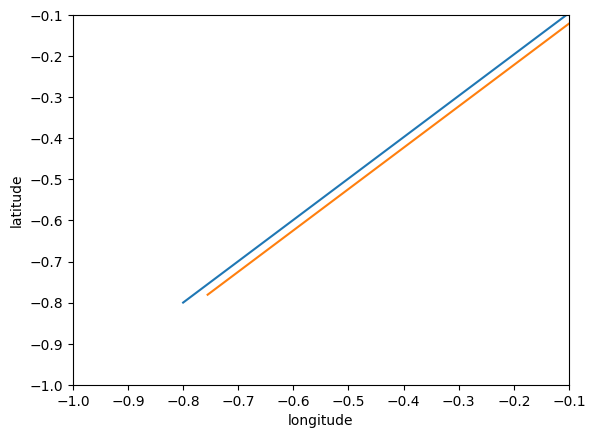

In [11]:
# visualise the fleet
ax = plt.axes()
ax.set_xlim([lons[0], lons[-1]])
ax.set_ylim([lats[0], lats[-1]])
for i in fl:
    i.plot(ax=ax)

In [12]:
# simulate plume dispersion/advection using dry advection model
fl_df, pl_df = fl_gen.sim_plumes()

pl_df

,flight_id,waypoint,fuel_flow,true_airspeed,co2_m,h2o_m,so2_m,nox_m,co_m,hcho_m,...,nvpm_m,time,longitude,latitude,level,width,heading,sin_a,cos_a,altitude
0,0.0,0,0.869221,100.226641,2.740528e-07,1.066724e-07,7.284947e-11,1.151000e-09,4.861864e-11,5.691939e-13,...,6.218223e-12,2022-03-02 14:05:00,-0.800000,-0.800000,209.158358,95.096588,45.003804,0.707154,0.707060,11500.0
12,0.0,1,0.869221,100.227482,2.740504e-07,1.066715e-07,7.284883e-11,1.150990e-09,4.861822e-11,5.691889e-13,...,6.218168e-12,2022-03-02 14:05:00,-0.723776,-0.723258,209.158358,63.385850,45.003804,0.707154,0.707060,11500.0
24,0.0,2,0.869221,100.228235,2.740482e-07,1.066707e-07,7.284826e-11,1.150981e-09,4.861784e-11,5.691844e-13,...,6.218120e-12,2022-03-02 14:05:00,-0.647552,-0.646515,209.158358,42.889939,45.003364,0.707148,0.707065,11500.0
120,1.0,0,0.869221,100.226860,2.740521e-07,1.066722e-07,7.284930e-11,1.150997e-09,4.861853e-11,5.691926e-13,...,6.218209e-12,2022-03-02 14:05:00,-0.755532,-0.780815,209.158358,95.096588,45.003689,0.707152,0.707061,11500.0
132,1.0,1,0.869221,100.227679,2.740498e-07,1.066713e-07,7.284868e-11,1.150988e-09,4.861812e-11,5.691877e-13,...,6.218156e-12,2022-03-02 14:05:00,-0.679308,-0.704073,209.158358,63.385850,45.003689,0.707152,0.707061,11500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,1.0,7,0.869220,100.229779,2.740438e-07,1.066690e-07,7.284709e-11,1.150962e-09,4.861706e-11,5.691753e-13,...,6.218020e-12,2022-03-02 15:10:00,-0.221964,-0.243619,209.158358,1806.063778,45.003486,0.707150,0.707064,11500.0
226,1.0,8,NaN,100.229034,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2022-03-02 15:10:00,-0.145744,-0.166875,209.158358,1717.064719,45.002076,0.707132,0.707081,11500.0
107,0.0,8,0.869220,100.228994,2.740461e-07,1.066698e-07,7.284769e-11,1.150972e-09,4.861745e-11,5.691799e-13,...,6.218071e-12,2022-03-02 15:15:00,-0.190212,-0.186060,209.158358,1942.279695,45.005125,0.707170,0.707044,11500.0
119,0.0,9,NaN,100.229121,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2022-03-02 15:15:00,-0.113994,-0.109315,209.158358,1851.109646,45.005125,0.707170,0.707044,11500.0


In [13]:
fl_gen.anim_fl(fl_df, pl_df)

In [14]:
# convert plume dataframe to EMI geospatial xarray dataset
emi = fl_gen.plume_to_grid()

Processing time:  2022-03-02 14:05:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:10:00


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:15:00


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:20:00


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:25:00


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:30:00


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:35:00


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:40:00


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:45:00


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:50:00


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:55:00


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:05:00


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:10:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:15:00


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# init boxm simulation and generate chemistry dataset
boxm = Boxm(met=met, params=chem_params)
bg_chem = boxm.bg_chem

/home/ktait98/miniconda3/envs/contrails/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 5MB
Dimensions:     (latitude: 36, longitude: 72, level: 9)
Coordinates:
  * latitude    (latitude) int64 288B -90 -85 -80 -75 -70 -65 ... 65 70 75 80 85
  * longitude   (longitude) int64 576B -180 -175 -170 -165 ... 160 165 170 175
  * level       (level) float64 72B 962.0 861.0 759.0 ... 353.0 251.0 150.5
    month       int64 8B 2
    time        datetime64[ns] 8B 2022-03-01T21:00:00
Data variables: (12/220)
    O1D         float64 8B 0.0
    O           float64 8B 0.0
    OH          float64 8B 0.0
    NO2         (latitude, longitude, level) float64 187kB 0.001687 ... 0.02065
    NO3         float64 8B 0.0
    O3          (latitude, longitude, level) float64 187kB 22.86 26.89 ... 141.9
    ...          ...
    P3613       float64 8B 0.0
    P3442       float64 8B 0.0
    CH3O2NO2    float64 8B 0.0
    EMPOA       float64 8B 0.0
    P2007       (latitude, longitude, level) float64 187kB 5.113e-11 ... 1.54...
    RN902       float64 8B 0.0


: 

In [17]:
# run boxm simulation
chem = boxm.eval(emi)

<xarray.DataArray 'time' (time: 289)> Size: 2kB
array(['2022-03-01T21:00:00.000000000', '2022-03-01T21:05:00.000000000',
       '2022-03-01T21:10:00.000000000', ..., '2022-03-02T20:50:00.000000000',
       '2022-03-02T20:55:00.000000000', '2022-03-02T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 2022-03-01T21:00:00 ... 2022-03-02T21:...


/home/ktait98/pycontrails_kt/pycontrails/physics/geo.py:630: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return (time - time.astype("datetime64[D]")) / np.timedelta64(1, "h")
/home/ktait98/pycontrails_kt/pycontrails/physics/geo.py:630: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Var

In [ ]:
# chem